# Simple resnet layer implementation
Following the implicit layers tutorial

In [2]:
def anderson_resnet(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)

        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [4]:
class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))

In [5]:
X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
out = anderson_resnet(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)

C:\Users\weipy\AppData\Local\Temp\ipykernel_31736\2317070265.py:19: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)


Text(0, 0.5, 'Relative residual')

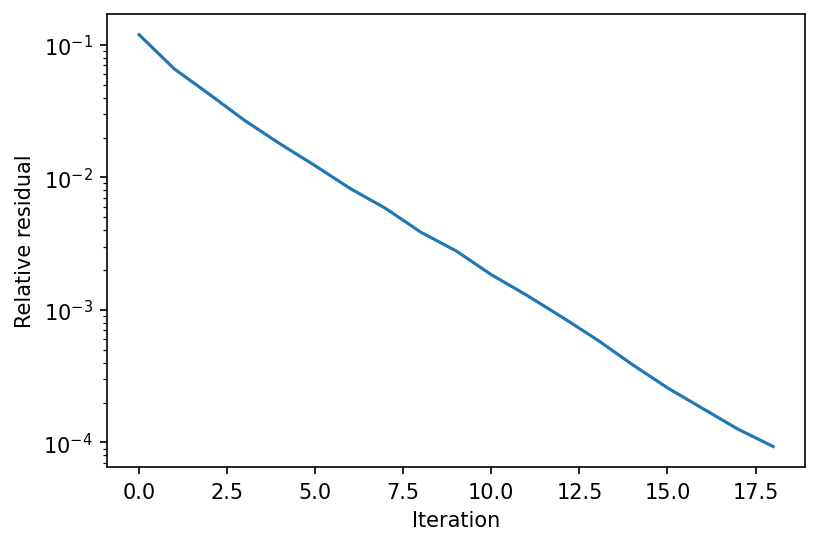

In [6]:
plt.figure(dpi=150)
plt.semilogy(out[1])
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

# DEQLAYER
Test implementation of deq bert by using gradcheck to make sure backward pass is computed correctly.

In [2]:
from DEQBert.solvers import broyden, anderson
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from transformers.models.roberta.modeling_roberta import RobertaLayer, RobertaEmbeddings
from transformers.models.roberta.configuration_roberta import RobertaConfig
from transformers import RobertaTokenizer

import matplotlib.pyplot as plt

from typing import Optional, Tuple

C:\Users\weipy\mambaforge\envs\deqbert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialise the weights with smaller values

In [27]:
# Variant of the bertdeq layer, only change being the output dict's stored residuals is stored into self.forward/backward_res
class DEQRobertaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = RobertaLayer(config)
        self.hook = None

        self.f_solver = broyden
        self.b_solver = broyden
        self.f_thres = 100
        self.b_thres = 100

    def residual_forward(self,
                         hidden_states: torch.Tensor,
                         initial_hidden_state: torch.Tensor,
                         attention_mask: Optional[torch.FloatTensor] = None,
                         head_mask: Optional[torch.FloatTensor] = None,
                         encoder_hidden_states: Optional[torch.FloatTensor] = None,
                         encoder_attention_mask: Optional[torch.FloatTensor] = None,
                         past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
                         output_attentions: Optional[bool] = False
                         ):
        out = list(self.layer(hidden_states, attention_mask, head_mask, encoder_hidden_states,
                   encoder_attention_mask, past_key_value, output_attentions))
        out[0] = F.layer_norm(initial_hidden_state + out[0], (self.config.hidden_size,))

        return tuple(out)

    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            head_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
            past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
            output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # output of robertalayer that we want is wrapped in tuple since extra elements are provided if is_decoder=True
        f = lambda x: self.residual_forward(x, hidden_states, attention_mask, head_mask, encoder_hidden_states,encoder_attention_mask, past_key_value, output_attentions)[0]

        # initial estimate of fixed_point. Will heavily influence the output.
        z0 = torch.zeros_like(hidden_states)

        # Forward pass
        with torch.no_grad():
            out = self.f_solver(f, z0, threshold=self.f_thres)
            self.forward_out = out
            #print(f"forward out nstep: {out['nstep']}")
            z_star = out['result']
            new_z_star = z_star

        # (Prepare for) Backward pass
        if self.training:
            new_z_star = f(z_star.requires_grad_())

            def backward_hook(grad):
                if self.hook is not None:
                    self.hook.remove()
                    torch.cuda.synchronize()  # To avoid infinite recursion
                # Compute the fixed point of yJ + grad, where J=J_f is the Jacobian of f at z_star
                #print(f"new_z_star: {new_z_star.size()}, z_star: {z_star.size()}")
                out = self.b_solver(lambda y: autograd.grad(new_z_star, z_star, y, retain_graph=True)[0] + grad,
                                         torch.zeros_like(grad), threshold=self.b_thres)
                self.backward_out = out
                #print(f"backward out nstep: {out['nstep']}")
                new_grad = out['result']
                return new_grad

            self.hook = new_z_star.register_hook(backward_hook)


        #print(f"self.training {self.training}")
        #print(f"DEQ RobertaLayer forward pass hidden_states of shape {hidden_states.shape}: {hidden_states}")
        #print(f"DEQRobertaLayer z_star: {z_star}")
        #print(f"DEQRobertaLayer forward pass output: {new_z_star}")

        return (new_z_star,)

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

In [1]:
from DEQBert.modeling_deqbert import DEQBertLayer
from DEQBert.configuration_deqbert import DEQBertConfig
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(0)

C:\Users\weipy\mambaforge\envs\deqbert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def init_weights(module):
    """ Initialize the weights """
    if isinstance(module, (nn.Linear, nn.Embedding)):
        # Slightly different from the TF version which uses truncated_normal for initialization
        # cf https://github.com/pytorch/pytorch/pull/5617
        module.weight.data.normal_(0, 0.01)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.zero_()

In [3]:
config = DEQBertConfig(is_decoder=False, training=False, hidden_size=12)
layer_double = DEQBertLayer(config)
#layer_double = DEQRobertaLayer(config)
layer_double = layer_double.apply(init_weights)
layer_double = layer_double.double()
layer_double

DEQBertLayer(
  (attention): DEQBertAttention(
    (self): DEQBertSelfAttention(
      (query): Linear(in_features=12, out_features=12, bias=True)
      (key): Linear(in_features=12, out_features=12, bias=True)
      (value): Linear(in_features=12, out_features=12, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): DEQBertSelfOutput(
      (dense): Linear(in_features=12, out_features=12, bias=True)
      (LayerNorm): LayerNorm((12,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): DEQBertIntermediate(
    (dense): Linear(in_features=12, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): DEQBertOutput(
    (dense): Linear(in_features=3072, out_features=12, bias=True)
    (LayerNorm): LayerNorm((12,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (input_injection): Conv1d(12, 36, kernel_size=(1,), stride=(1,))
)

Is gradcheck supposed to take so long?

In [ ]:
from torch.autograd import gradcheck

# (batch size, seq_len, hidden_size)
input_tensor = torch.randn((1, 2, 12)).requires_grad_().double()

gradcheck(layer_double, input_tensor, eps=1e-5, atol=1e-3, check_undefined_grad=False)

Plot the residuals

In [3]:
config = DEQBertConfig(is_decoder=False, training=False)
layer = DEQBertLayer(config)
#layer = DEQRobertaLayer(config)
layer = layer.apply(init_weights)

In [4]:
input_tensor = torch.randn((1, 12, 768))
out = layer(input_tensor)[0]
(out*torch.randn_like(out)).sum().backward()

[]

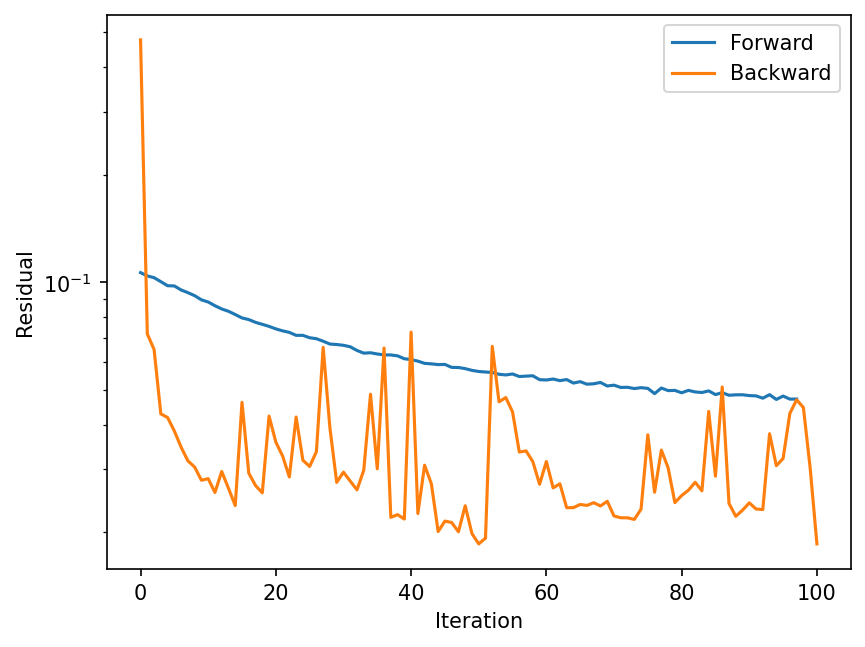

In [5]:
plt.figure(dpi=150)
plt.semilogy(layer.forward_out['rel_trace'])
plt.semilogy(layer.backward_out['rel_trace'])
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.plot()

In [6]:
out

tensor([[[-0.7136,  0.9692, -0.7673,  ...,  0.2413,  0.3703,  0.9100],
         [-0.7159,  1.1391, -0.4659,  ...,  0.0855, -0.0296,  0.8198],
         [-0.8295,  1.1305, -0.6898,  ...,  0.6274,  0.3253,  0.9733],
         ...,
         [-0.6219,  1.2289, -0.8222,  ...,  0.2426, -0.0629,  0.7790],
         [-0.8656,  1.3535, -0.9328,  ...,  0.1657,  0.4170,  0.7839],
         [-0.8130,  0.9865, -0.6194,  ...,  0.2465,  0.3333,  1.1515]]],
       grad_fn=<TransposeBackward0>)

In [6]:
import torch
from DEQBert.DEQBert import DEQBertModel
from DEQBert.configuration_bertdeq import DEQBertConfig

In [2]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
encoded = tokenizer("What the dog doing", return_tensors='pt')
encoded

{'input_ids': tensor([[   0, 2264,    5, 2335,  608,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [3]:
inputs = {'input_ids': torch.tensor([[   0, 2264,    5, 2335,  608,    2]]), 'attention_mask': torch.tensor([[1, 1, 1, 1, 1, 1]])}
inputs

{'input_ids': tensor([[   0, 2264,    5, 2335,  608,    2]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [7]:
config = DEQBertConfig(is_decoder=False, training=False)
model = DEQBertModel(config)
model

DEQBertModel(
  (embeddings): DEQBertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768, padding_idx=1)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DEQBertEncoder(
    (layer): DEQBertLayer(
      (attention): DEQBertAttention(
        (self): DEQBertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): DEQBertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
 

In [8]:
outputs = model(**inputs)
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1430,  1.1405,  0.6251,  ...,  0.3789,  1.4346, -0.2325],
         [ 0.0027,  1.2109,  0.5534,  ...,  0.3453,  1.3064, -0.3859],
         [ 0.1024,  1.0308,  0.3982,  ...,  0.5437,  1.2036, -0.3357],
         [-0.0193,  1.1162,  0.6326,  ...,  0.3878,  1.1348, -0.3442],
         [ 0.1360,  1.3013,  0.5478,  ...,  0.3280,  1.3134, -0.4334],
         [-0.0654,  0.9487,  0.7723,  ...,  0.5585,  1.3642, -0.4237]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 1.5409e-01,  9.3985e-02, -2.5199e-01, -1.0876e-01, -6.4360e-02,
         -2.0741e-01, -1.2550e-02, -4.4392e-01,  2.7974e-01,  2.6721e-01,
          1.4758e-01,  1.1721e-01, -3.9298e-02,  3.7020e-01, -1.6553e-01,
         -7.8924e-02, -3.6945e-01,  2.6854e-01,  1.3302e-01,  4.0502e-01,
          3.3531e-01,  2.9118e-01,  2.9858e-01,  2.0991e-02,  1.1736e-01,
         -9.5480e-02,  5.3183e-02, -3.7841e-01,  3.7835e-01, -2.1204e-02,
       

In [9]:
for name, param in model.named_parameters():
    print(f"{name}: {param}")

embeddings.word_embeddings.weight: Parameter containing:
tensor([[ 1.3391e-02,  8.2031e-03,  1.2461e-03,  ..., -7.4719e-03,
          3.1267e-03, -1.0992e-02],
        [ 6.5783e-03, -7.7868e-03,  3.9621e-03,  ..., -5.3509e-03,
         -1.8378e-02, -8.9118e-03],
        [-7.4516e-04,  2.3479e-03,  1.3764e-02,  ...,  9.3458e-03,
         -1.3464e-02, -2.1224e-02],
        ...,
        [ 8.9008e-03, -1.2705e-02, -1.8076e-02,  ..., -1.1789e-02,
          1.1158e-02,  9.0475e-04],
        [ 1.0517e-02, -1.5456e-02, -4.3390e-04,  ...,  1.5967e-02,
          7.4998e-03,  6.5314e-05],
        [ 3.0470e-03,  1.3040e-02, -9.8449e-03,  ..., -1.8422e-03,
          1.0519e-02,  1.0407e-02]], requires_grad=True)
embeddings.position_embeddings.weight: Parameter containing:
tensor([[-0.0044, -0.0077,  0.0043,  ..., -0.0045, -0.0008,  0.0067],
        [-0.0033, -0.0091, -0.0101,  ...,  0.0047,  0.0112, -0.0027],
        [ 0.0028,  0.0002,  0.0047,  ...,  0.0155, -0.0039,  0.0126],
        ...,
       

# Testing the trained model

In [1]:
from DEQBert.modeling_deqbert import DEQBertForMaskedLM, DEQBertConfig
from DEQBert.tokenization_deqbert import DEQBertTokenizer
from transformers import pipeline

C:\Users\weipy\mambaforge\envs\deqbert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = "DEQBert/model_card/config.json"
model_path = "models/lucas-cont/checkpoint-60000"

In [3]:
# create tokenizer
tokenizer = DEQBertTokenizer.from_pretrained("roberta-base")

# create the model
model = DEQBertForMaskedLM.from_pretrained(model_path)

# create fill mask pipeline
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

Downloading: 100%|██████████| 899k/899k [00:03<00:00, 256kB/s] 
C:\Users\weipy\mambaforge\envs\deqbert\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\weipy\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Downloading: 100%|██████████| 456k/456k [00:02<00:00, 225kB/s]  
Downlo

In [5]:
fill_mask("The nurse notified the patient that <mask> shift would be ending in an hour..")

[{'score': 0.37471240758895874,
  'token': 5,
  'token_str': ' the',
  'sequence': 'The nurse notified the patient that the shift would be ending in an hour..'},
 {'score': 0.1360352635383606,
  'token': 10,
  'token_str': ' a',
  'sequence': 'The nurse notified the patient that a shift would be ending in an hour..'},
 {'score': 0.0531623512506485,
  'token': 42,
  'token_str': ' this',
  'sequence': 'The nurse notified the patient that this shift would be ending in an hour..'},
 {'score': 0.04111242666840553,
  'token': 18,
  'token_str': "'s",
  'sequence': "The nurse notified the patient that's shift would be ending in an hour.."},
 {'score': 0.013586561195552349,
  'token': 74,
  'token_str': ' would',
  'sequence': 'The nurse notified the patient that would shift would be ending in an hour..'}]

## Comparing the model parameter count

In [19]:
from transformers import RobertaForMaskedLM
RobertaForMaskedLM.from_pretrained("roberta-base").num_parameters()

124697433

In [18]:
model.num_parameters()

48502617

The DEQ has 1/3 the parameter count of the Roberta model.